# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [1]:
# This is a modification in using our own imageNet data on the author trained GoogleNet 

import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

We first load the model files and set the top layers' name.

In [2]:
if not os.path.isfile('../models/COCO/GoogleNetCOCO.caffemodel'):
    url = 'http://www.cs.bu.edu/groups/ivc/data/ExcitationBP/COCO/GoogleNetCOCO.caffemodel'
    urllib.urlretrieve(url, '../models/COCO/GoogleNetCOCO.caffemodel')
caffe.set_mode_gpu()
net = caffe.Net('../models/COCO/deploy.prototxt',
                '../models/COCO/GoogleNetCOCO.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../models/COCO/catName.txt')
param = dict()
imgScale = 224
topBlobName = 'loss3/classifier'
topLayerName = 'loss3/classifier'
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = 'pool5/7x7_s1'

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

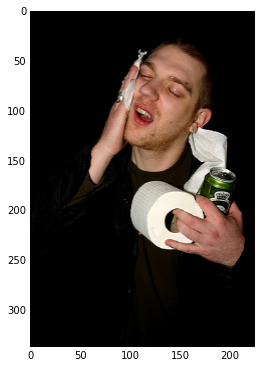

In [3]:
imgName = '/data1/imagenet-data/raw-data/train/n15075141/n15075141_999.JPEG'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
# newSize = ( imgScale, imgScale)
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [4]:
print (imgS.shape)
print (newSize[0], newSize[1])

net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = topLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

(336, 224, 3)
(336, 224)
[('person', 0.97984403), ('remote', 0.010588896), ('bottle', 0.0023961521), ('cup', 0.0014110459), ('dining table', 0.0011916721), ('cell phone', 0.0008675619), ('couch', 0.00038655865), ('clock', 0.0003859319), ('book', 0.00036963276), ('chair', 0.00032588193)]


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

[[ 0.14913447]
 [ 0.17095481]
 [ 0.26607132]
 [ 0.41383949]]
(80, 1024, 1, 1)
(1, 1024, 4, 1)
[[ 0.18388955]
 [ 0.20085208]
 [ 0.27240804]
 [ 0.34285033]]
(80, 1024, 1, 1)
(1, 1024, 4, 1)
[[ 0.24841799]
 [ 0.20608877]
 [ 0.24454002]
 [ 0.30095318]]
(80, 1024, 1, 1)
(1, 1024, 4, 1)
[[ 0.20639193]
 [ 0.37522885]
 [ 0.27229902]
 [ 0.1460802 ]]
(80, 1024, 1, 1)
(1, 1024, 4, 1)


/usr/local/lib/python2.7/dist-packages/skimage/_shared/utils.py:174: skimage_deprecation: Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be removed in a future release.
  "Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be "


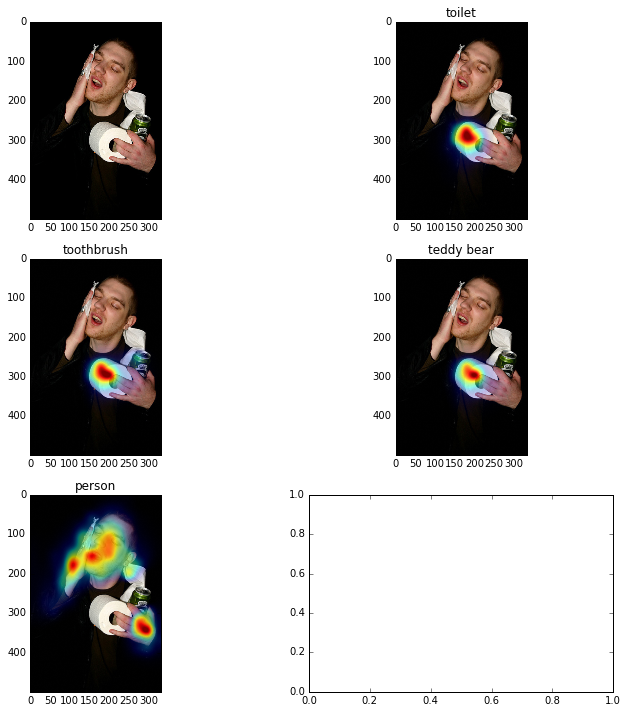

In [5]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['toilet', 'toothbrush', 'teddy bear', 'person']
#specify the output lyer name
outputLayerName = 'pool3/3x3_s2'#'inception_5b/output'
outputBlobName = 'pool3/3x3_s2'#'inception_5b/output'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()
    print( net.blobs[topBlobName].diff[0][tagID] )
    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()
    print net.params[topLayerName][0].data.shape
    print buff.shape
    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


We also compare with the deconvolution method.

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


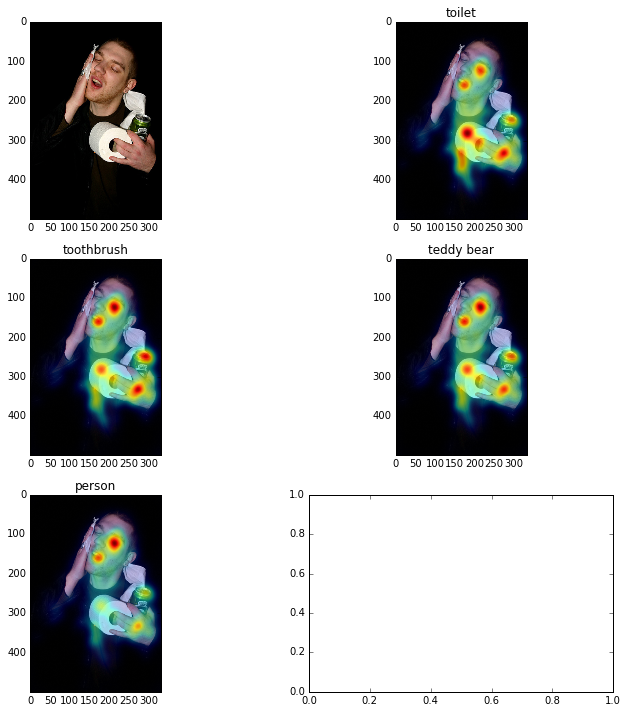

In [6]:
# switch to the deconvolution mode
caffe.set_mode_dc_gpu() 
tagName = ['toilet', 'toothbrush', 'teddy bear', 'person']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)

Compare with the gradient method

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


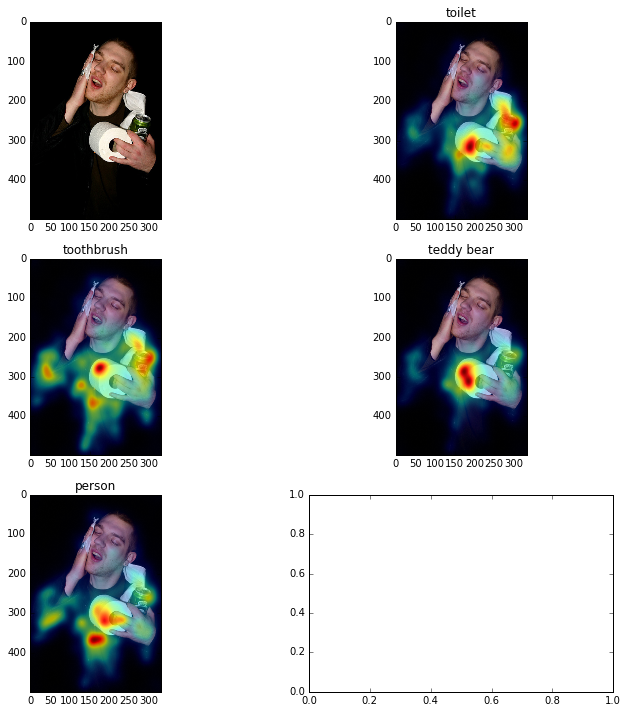

In [7]:
# Switch to the normal error backpropagation mode
caffe.set_mode_gpu() 
tagName = ['toilet', 'toothbrush', 'teddy bear', 'person']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)